# AfterWork Data Science: Basics of Deep Learning and Neural Networks 

## <font color='#2F4F4F'>1. Defining the Question</font>

### a) Specifying the Data Analysis Question

Develop computer vision models that can be used to determine the age of a person from a photo

### b) Defining the Metric for Success

This project will be considered a success when:
* we are able to confidently predict someone's age depending on their picture, and
* we get a regression model with an SI that is less than 30%

### c) Understanding the Context 
The Good Seed supermarket chain would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:
* The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
* Computer vision methods can be used to determine the age of a person from a photo.
* The task then is to build and evaluate a model for verifying people's age.

### d) Recording the Experimental Design

1. Load dataset and libraries.
2. Clean dataset.
3. Carry out univariate analysis.
4. Carry out data modeling.
5. Model Evaluation
6. Summarize findings.
7. Provide recommendations.
8. Challenge the solution.

### e) Data Relevance

The data provided is sufficient and appropriate for answering the research question.

## <font color='#2F4F4F'>2. Data Cleaning & Preparation</font>

### 2.1 Loading necessary libraries

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile

from PIL import Image

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os, os.path

pd.set_option('display.max.columns', None)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

In [238]:
# extract the images from zip files
# !7z x images.zip
# !jar xvf images.zip

### 2.2 Data Wrangling

In [239]:
# check the number of images
DIR  = 'images/'
files = os.listdir(DIR)
print(len(files))
files = sorted(files)
print(files[0],files[-1])

7591
000000.jpg 007612.jpg


There are 7591 images in the folder

In [240]:
# load the data into our dataframe
df = pd.read_csv('labels.csv')
print(df.shape)
df

(7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


the number of images and the number of records in our labels dataframe tally, we are good to go

In [241]:
df.dtypes

file_name    object
real_age      int64
dtype: object

In [242]:
# view age statistics
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


* youngest person is 1 year old while the oldest is 100 years old
* The mean age of the population is 31 years

### 2.3 View Sample Images

In [243]:
samples = df.sample(8)
samples

,file_name,real_age
6432,006436.jpg,31
1951,001951.jpg,30
4968,004968.jpg,61
3261,003261.jpg,18
2685,002685.jpg,7
6714,006721.jpg,6
7171,007188.jpg,29
660,000660.jpg,19


In [244]:
samples['file_name'].values[0]

'006436.jpg'

In [245]:
# convert to an array
arr_sample = samples['file_name'].values
arr_sample

array(['006436.jpg', '001951.jpg', '004968.jpg', '003261.jpg',
       '002685.jpg', '006721.jpg', '007188.jpg', '000660.jpg'],
      dtype=object)

In [246]:
len(arr_sample)

8

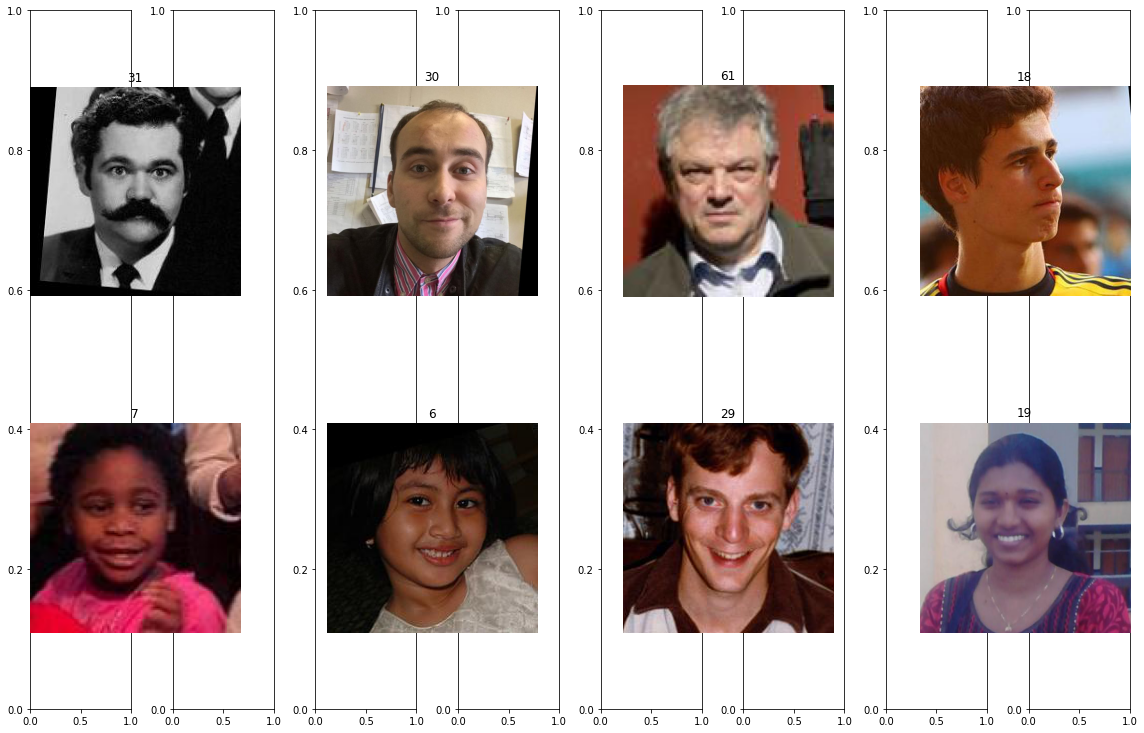

In [247]:
fig, ax = plt.subplots(nrows=1,ncols=len(arr_sample),figsize=(4*4,5*2))
for i in range(0,len(arr_sample)):
    fig.add_subplot(2,4, i+1)
    image = Image.open(DIR + arr_sample[i])
    im = np.array(image)
#     print(im.shape)
    plt.imshow(im)
#     remove axes    
    plt.axis('off')
    plt.grid(None)
    plt.title(str(samples['real_age'].values[i]))
    
plt.tight_layout() 
plt.show()


## <font color='#2F4F4F'>3. Data Analysis</font>

### 3.1 Univariate Analysis

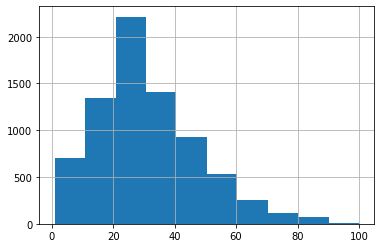

In [248]:
# Distribution of the age
df.real_age.hist()
plt.show()

Majority of the employees are between 10-40 years of age. <br>
The distribution is skewed slightly to the right and not completely normal/Gaussian. 

## <font color='#2F4F4F'>4. Data Modeling</font>

In [249]:
# split the dataframe into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
print(train_df.shape)
print(test_df.shape)

(6072, 2)
(1519, 2)


In [250]:
# create our data generator for the training dataset
# split the training into 75% training and 25% validation
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [251]:
# create a training set generator
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="images/",
    x_col="file_name",
    y_col="real_age",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(200,200)
)
# preview the file names
train_generator.filenames[:5]

Found 4554 validated image filenames.


['002804.jpg', '001922.jpg', '002805.jpg', '004760.jpg', '004848.jpg']

In [252]:
# create a validation set generator
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="images/",
    x_col="file_name",
    y_col="real_age",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(200,200)
)
# preview the file names
valid_generator.filenames[:5]

Found 1518 validated image filenames.


['004405.jpg', '006265.jpg', '005216.jpg', '005970.jpg', '001614.jpg']

In [253]:
# create our data generator for the test dataset
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="images/",
    x_col="file_name",
    y_col="real_age",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="raw",
    target_size=(200,200)
)
# preview the file names
test_generator.filenames[:5]

Found 1519 validated image filenames.


['002563.jpg', '006066.jpg', '004395.jpg', '004320.jpg', '004072.jpg']

In [254]:
# # build the model

# # initialize the model
# model = Sequential()

# # first convolution layer (input layer) with 32 filters of size 3x3, and padding
# # same sets the size of the padding automatically so that the width and height of the output tensor is equal 
# # to the width and height of the input tensor.
# model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(200,200,3), activation='relu'))
# # reduce the number of the model's parameters using Max Pooling with kernel size of 2x2
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # Add Dropout regularization functions to hidden layers in order to prevent overfitting
# model.add(Dropout(0.25))

# # Second convolution layer
# model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # Third convolution layer
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # In order for the results of the convolutional layer to be compatible with a fully connected layer, connect a new layer named Flatten. 
# # It makes the multidimensional tensor one-dimensional.
# model.add(Flatten())

# # fully connected hidden layer with 64 neurons
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

# # output layer
# # 'output dimension' is 1 since we are predicting one age each time.
# model.add(Dense(units = 1))

# # compile the model
# model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

In [255]:
# build an ANN model using ResNet architecture

# initialize the model
model = Sequential()

# we will use ResNet50 architecture, with freezing top layers
backbone = ResNet50(input_shape=(200,200,3), weights='imagenet', include_top=False)
model.add(backbone)

# reduce the number of the model's parameters using Global Average Pooling
model.add(GlobalAveragePooling2D())
# Add Dropout regularization functions to hidden layers in order to prevent overfitting
model.add(Dropout(0.25))


# output layer
# since we are doing regression we will add only one neuron (unit)
model.add(Dense(units = 1,activation='relu'))

# The Adam algorithm makes stride selection automatic. 
# It selects different parameters for different neurons, which speeds up model training.
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

In [256]:
train_generator.n

4554

In [257]:
len(train_generator)

143

In [258]:
train_generator.batch_size

32

In [259]:
test = train_generator.n/train_generator.batch_size
test

142.3125

In [260]:
STEP_SIZE_TRAIN=len(train_generator)
STEP_SIZE_VALID=len(valid_generator)
STEP_SIZE_TEST=len(test_generator)

In [261]:
# fitting the model
model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=10
)

Epoch 1/10
143/143 [==============================] - 59s 378ms/step - loss: 307.9244 - mean_squared_error: 307.9244 - val_loss: 475.8824 - val_mean_squared_error: 475.8824
Epoch 2/10
143/143 [==============================] - 53s 367ms/step - loss: 78.7420 - mean_squared_error: 78.7420 - val_loss: 445.3695 - val_mean_squared_error: 445.3695
Epoch 3/10
143/143 [==============================] - 54s 376ms/step - loss: 44.5877 - mean_squared_error: 44.5877 - val_loss: 725.2240 - val_mean_squared_error: 725.2240
Epoch 4/10
143/143 [==============================] - 53s 367ms/step - loss: 24.4415 - mean_squared_error: 24.4415 - val_loss: 369.6903 - val_mean_squared_error: 369.6903
Epoch 5/10
143/143 [==============================] - 53s 369ms/step - loss: 22.4118 - mean_squared_error: 22.4118 - val_loss: 147.2759 - val_mean_squared_error: 147.2759
Epoch 6/10
143/143 [==============================] - 53s 367ms/step - loss: 20.4817 - mean_squared_error: 20.4817 - val_loss: 123.9328 - val_m

In [262]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [263]:
# evaluate the model
model.evaluate(valid_generator,steps=STEP_SIZE_TEST)

48/48 [==============================] - 9s 180ms/step - loss: 86.2654 - mean_squared_error: 86.2654


[86.26543426513672, 86.26543426513672]

In [264]:
# Predict the output
test_generator.reset()
predicted_ages = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

48/48 [==============================] - 9s 180ms/step


In [265]:
predicted_ages[:5]

array([[10.407612],
       [34.785503],
       [ 6.18701 ],
       [62.257587],
       [33.201485]], dtype=float32)

In [266]:
len(predicted_ages)

1519

In [267]:
test_generator.n

1519

### Step 5: Model Evaluation

In [268]:
real_ages = test_df.iloc[:, 1:].values
real_ages[:5]

array([[ 7],
       [34],
       [ 1],
       [59],
       [31]])

In [269]:
rmse = np.sqrt(mean_squared_error(real_ages, predicted_ages))
rmse

9.281574208079807

In [270]:
average = real_ages.mean()
average

31.448979591836736

In [271]:
# calculate the relative RMSE using scatter index
scatter_index = rmse/average * 100
scatter_index

29.513117209338773

In [273]:
# check if our RMSE is within the acceptable threshold
if scatter_index <= 30:
    print('Good Model')
else:
    print('Poor Model')

Good Model


The CNN model achieved an RMSE of 9.28 which is considered good for the model to be used to predict ages of people based on their photos

## <font color='#2F4F4F'>6. Summary of Findings</font>

Using ResNet50 architecture our CNN model achieved an RMSE of 9.28 which is considered good for the model to be used to predict ages of people based on their photos

## <font color='#2F4F4F'>7. Recommendations</font>


The Good Seed supermarket can rely on this CNN odel to determine the age of their customers and ensure alcohol is not sold to underage people

## <font color='#2F4F4F'>8. Challenging our Solution</font>


#### a) Did we have the right question?
<i>The research question enabled us to achieve the data analysis objectives</i>

#### b) Did we have the right data?
<i>The data was relevant in addressing the set objectives</i>

#### c) What can be done to improve the solution?
<i>
We can improve our model by:
<li>Optimizing the epochs.</li>
<li>Optimizing the number of layers.</li>
<li>Optimizing the number of nodes per layer.</li>
</i>